In [ ]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install librosa >> /dev/null
!pip install SoundFile >> /dev/null
!pip install resampy >> /dev/null

In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download data files
downloaded = drive.CreateFile({'id':"1TjujGTMC98a4d0smt0D8Ff3ohDOtJzEk"})
downloaded.GetContentFile('Colab_Data.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Colab_Data.zip', 'r') as zip_file:
    zip_file.extractall()

In [ ]:
import librosa
print(librosa.__version__)
import glob
import os
import pandas as pd
from xml.dom import minidom
from scipy import signal
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import random
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.patches as patches

0.10.2.post1


In [ ]:
# Paths
annotations_path = './Colab_Data/Annotations/'
original_audio_path = './Colab_Data/Audio/'
downsampled_audio_path = './Colab_Data/Downsampled_Audio/'


species_folder = './'
file_type = '.svl'
audio_extension = '.WAV'
training_files = './Colab_Data/train_multi.csv'


# Data hyper-parameters
# -----------------------------
downsample_rate = 20000
segment_duration = 2


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 2048
hop_length = 512
n_mels = 128

# To decide on these, you might want to work on a single audio file
# to figure out what are suitable values so that you can see the different events
# you might want to work in conjunction with SonicVisualiser + loaded annotations
# for a particular file

In [ ]:
# You most likely will not modify this
def get_annotation_information(file_name, audio_amps, sample_rate):

  # Process the .svl xml file
  xmldoc = minidom.parse(annotations_path+file_name+'.svl')
  itemlist = xmldoc.getElementsByTagName('point')
  idlist = xmldoc.getElementsByTagName('model')

  start_time = []
  end_time = []
  labels = []
  audio_file_name = ''

  print ('get annotation information')

  if (len(itemlist) > 0):

      print(file_name)

      # Iterate over each annotation in the .svl file (annotatation file)
      for s in itemlist:

          # Get the starting seconds from the annotation file. Must be an integer
          # so that the correct frame from the waveform can be extracted
          start_seconds = float(s.attributes['frame'].value)/sample_rate
          print('start_seconds', start_seconds)

          # Get the label from the annotation file
          label = str(s.attributes['label'].value)

          # If a file has a blank label then skip this annotation
          # to avoid mislabelling data
          if label == '':
              break

          # Get the duration from the annotation file
          annotation_duration_seconds = float(s.attributes['duration'].value)/sample_rate
          start_time.append(start_seconds)
          end_time.append(start_seconds+annotation_duration_seconds)
          labels.append(label)

  df_annotations = pd.DataFrame({'Start': start_time, 'End':end_time ,'Label': labels})
  return df_annotations, file_name+'.wav'

In [ ]:
def read_audio_file(file_name):
    y, sr = librosa.load(original_audio_path + file_name + '.WAV', sr = None)
    return y, sr

In [ ]:
y, sr = read_audio_file("20241112_030900_AIMS")

In [ ]:
def  read_annotation_file(file_name):
  xmldoc = minidom.parse(annotations_path+file_name+'.svl')
  itemlist = xmldoc.getElementsByTagName('point')

In [ ]:
df, _ = get_annotation_information("20241112_030900_AIMS", read_audio_file("20241112_030900_AIMS"), downsample_rate)
df

get annotation information
20241112_030900_AIMS
start_seconds 8.8256
start_seconds 25.8944
start_seconds 26.88
start_seconds 52.3712
start_seconds 68.7232
start_seconds 72.352
start_seconds 77.3248
start_seconds 83.0592
start_seconds 99.456
start_seconds 115.2256
start_seconds 115.2704
start_seconds 125.216
start_seconds 143.4496
start_seconds 145.1968
start_seconds 161.8176
start_seconds 199.136
start_seconds 218.3552
start_seconds 242.144
start_seconds 471.2064
start_seconds 497.1904
start_seconds 499.8336
start_seconds 506.7328
start_seconds 520.4864
start_seconds 549.248
start_seconds 571.648
start_seconds 817.6
start_seconds 1091.7312
start_seconds 1641.1584
start_seconds 1647.6096
start_seconds 1891.6352
start_seconds 1891.904
start_seconds 2047.8528
start_seconds 2048.256
start_seconds 2453.248
start_seconds 2552.928


Start        End Label
0      8.8256    15.4560     b
1     25.8944    39.2448     b
2     26.8800    30.8224     a
3     52.3712    61.2416     b
4     68.7232    71.5904     b
5     72.3520    75.9360     a
6     77.3248   101.9200     a
7     83.0592    90.7200     b
8     99.4560   104.4288     b
9    115.2256   119.8848     b
10   115.2704   121.3632     a
11   125.2160   131.1296     b
12   143.4496   147.2576     b
13   145.1968   148.2432     a
14   161.8176   168.9856     b
15   199.1360   209.4848     b
16   218.3552   227.2256     b
17   242.1440   251.4176     b
18   471.2064   483.2576     b
19   497.1904   511.9296     a
20   499.8336   501.8496     b
21   506.7328   508.3904     b
22   520.4864   531.8656     a
23   549.2480   556.1024     b
24   571.6480   578.6368     b
25   817.6000   828.6208     b
26  1091.7312  1120.0448     a
27  1641.1584  1645.0112     b
28  1647.6096  1652.0896     b
29  1891.6352  1894.6816     a
30  1891.9040  1893.5616     a
31  2047.8528  2054.0352     b
32  2048.2560  2053.4976     a
33  2453.2480  2456.0704     b
34  2552.9280  2557.7664     b

In [ ]:
# You most likely will not modify this
def getXY(audio_amplitudes, start_sec, annotation_duration_seconds,
          labels, sample_rate, verbose):

    if verbose == True:
        print ('start_sec', start_sec)
        print ('annotation_duration_seconds', annotation_duration_seconds)
        print ('segment_duration ', segment_duration )

    X_segments = []
    Y_labels = []

    # Calculate how many segments can be extracted based on the duration of
    # the annotated duration. If the annotated duration is too short then
    # simply extract one segment. If the annotated duration is long enough
    # then multiple segments can be extracted.
    if annotation_duration_seconds-segment_duration < 0:
        segments_to_extract = 1
    else:
        segments_to_extract = annotation_duration_seconds - segment_duration + 1

    if verbose:
        print ("segments_to_extract", segments_to_extract)

    for i in range (0, segments_to_extract):
        if verbose:
            print ('Semgnet {} of {}'.format(i, segments_to_extract-1))
            print ('*******************')

        # Set the correct location to start with.
        # The correct start is with respect to the location in time
        # in the audio file start+i*sample_rate
        start_data_observation = start_sec*sample_rate+i*(sample_rate)

        # The end location is based off the start
        end_data_observation = start_data_observation + (sample_rate*segment_duration)

        # This case occurs when something is annotated towards the end of a file
        # and can result in a segment which is too short.
        if end_data_observation > len(audio_amplitudes):
            continue

        # Extract the segment of audio
        X_audio = audio_amplitudes[start_data_observation:end_data_observation]

        if verbose == True:
            print ('start frame', start_data_observation)
            print ('end frame', end_data_observation)

        # Extend the segments and labels
        X_segments.append(X_audio)
        Y_labels.append(labels)

    return X_segments, Y_labels

In [ ]:
def process_overlaps(df, mlb):

    df = df.sort_values("Start").reset_index(drop=True)

    updated_rows = []
    current_start, current_end, current_label = df.iloc[0]

    for i in range(1, len(df)):
        next_start, next_end, next_label = df.iloc[i]

        if current_end > next_start:

            updated_rows.append({"Start": current_start, "End": next_start, "Label": current_label})

            # Overlap
            overlap_start = next_start
            overlap_end = min(current_end, next_end)
            combined_labels = ",".join(sorted(set(current_label.split(",") + next_label.split(","))))
            updated_rows.append({"Start": overlap_start, "End": overlap_end, "Label": combined_labels})


            current_start = overlap_end
            current_end = max(current_end, next_end)
            current_label = next_label if current_end == next_end else current_label
        else:
            # There is no overlap
            updated_rows.append({"Start": current_start, "End": current_end, "Label": current_label})
            current_start, current_end, current_label = next_start, next_end, next_label


    updated_rows.append({"Start": current_start, "End": current_end, "Label": current_label})


    result_df = pd.DataFrame(updated_rows)

    # Encoding labels
    label_matrix = mlb.fit_transform(result_df["Label"].str.split(","))
    label_df = pd.DataFrame(label_matrix, columns=mlb.classes_)

    # Combine time intervals with binary labels
    final_df = pd.concat([result_df.drop(columns=["Label"]), label_df], axis=1)

    return final_df



In [ ]:
def create_dataset(verbose, mlb):

        # Initialise lists to store the X and Y values
        X_calls = []
        Y_calls = []

        if verbose == True:
            print ('Annotations path:',annotations_path+"*.svl")
            print ('Audio path',original_audio_path+"*.wav")

        # Read all names of the training files
        training_file_names = pd.read_csv(training_files, header=None)

        # Iterate over each annotation file
        for training_file in training_file_names.values:

            filename = training_file[0]

            print ('Processing file:',filename)

            print('Looking for this file: ', original_audio_path+filename+audio_extension)
            print('From these files here: ', original_audio_path+"*"+audio_extension)

            # Check if the .wav file exists before processing
            if original_audio_path+filename+audio_extension  in glob.glob(original_audio_path+"*"+audio_extension):
                print('Found file')

                # Read audio file
                signal_downsampled, original_sample_rate = read_audio_file(filename)
                signal_downsampled = librosa.resample(y=signal_downsampled, orig_sr=original_sample_rate, target_sr = downsample_rate)

                # Get the start/stop time of each annotated event
                df, audio_file_name = get_annotation_information(filename, signal_downsampled,
                                                                 original_sample_rate)

                # The dataframe above will have a number of annotated events
                # each with a unique label. (i.e. not multi-label)
                # You need to combine these events
                # that overlap in time so that events with two or more labels
                # appear as a single row with the corresponding label
                # for example [1,1,0,0] means that event a and b happened.
                # Store the result in a variable called mult_label_df
                # as this will be a dataframe where you'll create a muli-label
                # dataset! Do not modify the name of this dataframe as it will
                # be used below, and you will be assessed on this.
                multi_label_df = process_overlaps(df, mlb)

                # You need to print this dataframe as you will be assessed on this
                print(multi_label_df)

                # At this point you would have a processed dataframe.
                # each row would be an acoustic event with one or more targets.
                # There are 4 possible targets
                # a, b, n and w
                # a = anthropohony (including human speech)
                # b = biophony
                # n = absence of sound event
                # w = wind
                # So example rows could be:
                # Start = 10, End = 12, a = 1, b= 0, n = 0, w= 1
                # Start = 20, End = 22, a = 0, b= 1, n = 0, w= 1
                # Start = 30, End = 32, a = 0, b= 1, n = 0, w= 0

                print('Reading annotations...')
                for index, row in multi_label_df.iterrows():

                    start_seconds = int(round(row['Start']))
                    end_seconds = int(round(row['End']))

                    # You might want to handle special cases where the current
                    # start window overlaps into another labelled event
                    # this happens when start + duration overlaps with the next event
                    # in the dataframe

                    # Note there is another special case, where the current event
                    # overlaps with the next, but the next event doesn't introduce
                    # new sounds, this you can include the next event

                    # Combine all the labels for this row
                    labels = [row['a'], row['b'], row['n'], row['w']]
                    annotation_duration_seconds = end_seconds - start_seconds

                    # Extract augmented audio segments and corresponding binary labels
                    X_data, y_data = getXY(signal_downsampled, start_seconds,
                                                annotation_duration_seconds,
                                           labels, downsample_rate, verbose)

                    # Append the segments and labels
                    X_calls.extend(X_data)
                    Y_calls.extend(y_data)

        # Convert to numpy arrays
        X_calls, Y_calls = np.asarray(X_calls), np.asarray(Y_calls)

        return X_calls, Y_calls

In [ ]:

# Initialize MultiLabelBinarizer for binary encoding
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])

X, Y = create_dataset(False, mlb)

Processing file: 20241112_030900_AIMS
Looking for this file:  ./Colab_Data/Audio/20241112_030900_AIMS.WAV
From these files here:  ./Colab_Data/Audio/*.WAV
Found file
get annotation information
20241112_030900_AIMS
start_seconds 3.6773333333333333
start_seconds 10.789333333333333
start_seconds 11.2
start_seconds 21.82133333333333
start_seconds 28.634666666666668
start_seconds 30.14666666666667
start_seconds 32.218666666666664
start_seconds 34.608
start_seconds 41.44
start_seconds 48.010666666666665
start_seconds 48.029333333333334
start_seconds 52.17333333333333
start_seconds 59.77066666666666
start_seconds 60.498666666666665
start_seconds 67.424
start_seconds 82.97333333333333
start_seconds 90.98133333333334
start_seconds 100.89333333333333
start_seconds 196.336
start_seconds 207.16266666666667
start_seconds 208.264
start_seconds 211.13866666666667
start_seconds 216.86933333333334
start_seconds 228.85333333333332
start_seconds 238.18666666666667
start_seconds 340.6666666666667
start_se

In [ ]:

S = librosa.feature.melspectrogram(y=X[0], sr=downsample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)


[0. 1. 0. 0.]


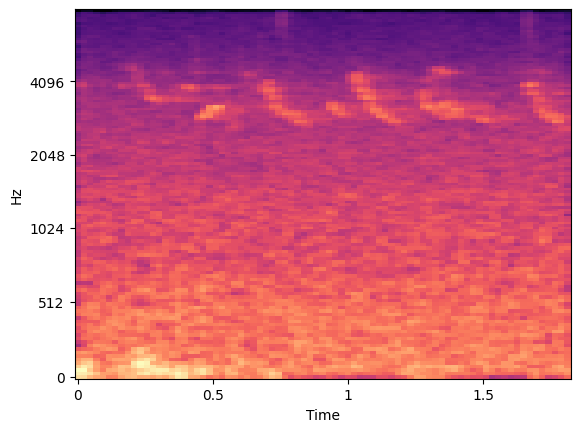

In [ ]:
i = 0
S = librosa.feature.melspectrogram(y=X[i], sr=downsample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
print(Y[i])

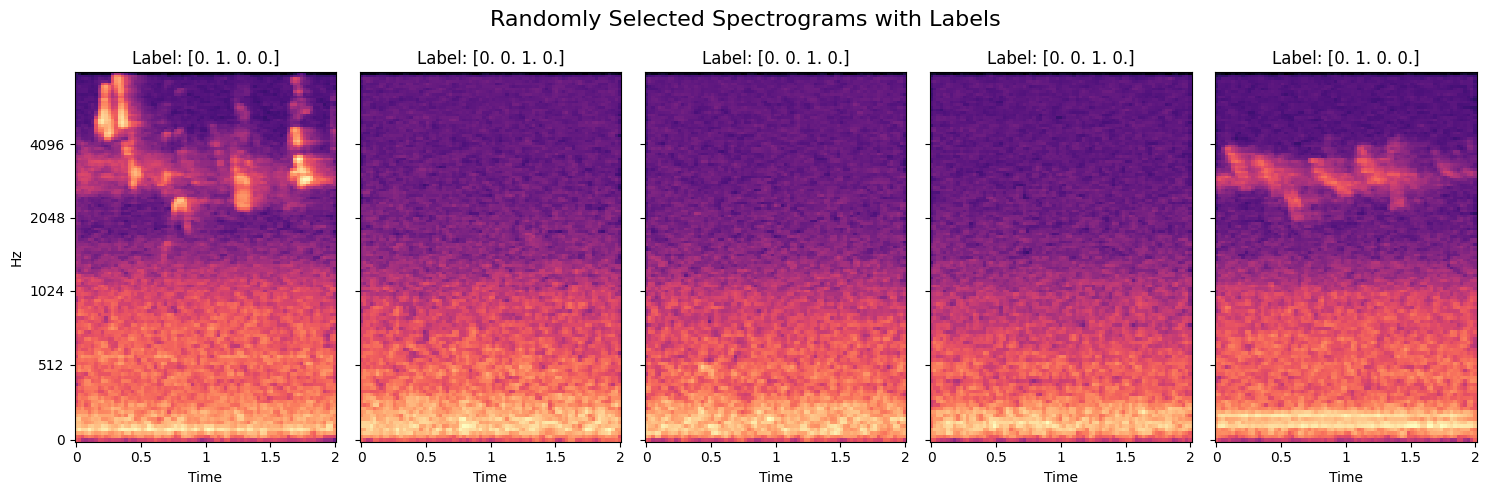

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np


num_spectrograms = 5
random_indices = np.random.choice(len(X), num_spectrograms, replace=False)

fig, axes = plt.subplots(1, num_spectrograms, figsize=(15, 5))
fig.suptitle("Randomly Selected Spectrograms with Labels", fontsize=16)

for idx, i in enumerate(random_indices):

    S = librosa.feature.melspectrogram(
        y=X[i], sr=downsample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    S_db = librosa.power_to_db(S, ref=np.max)


    img = librosa.display.specshow(
        S_db, sr=downsample_rate, hop_length=hop_length, x_axis='time', y_axis='mel', ax=axes[idx], fmax=8000
    )
    axes[idx].set_title(f"Label: {Y[i]}")
    axes[idx].label_outer()



plt.tight_layout()
plt.show()


In [ ]:
# print the shape of X and Y

X.shape, Y.shape

((2083, 40000), (2083, 4))

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Save to pickle file
# Save X and Y once this preprocessing step is done as this is time consuming!
import os
import pickle




In [ ]:
# Save to pickle file
# Save X and Y once this preprocessing step is done as this is time consuming!

def save_pickle(filename, var):
  path_folder = '/content/drive/MyDrive/DL4E'
  with open( os.path.join(path_folder,f'{filename}.pkl') , 'wb') as f:
    pickle.dump( var, f)

def load_pickle(filename):
  path_folder = '/content/drive/MyDrive/DL4E'
  with open( os.path.join(path_folder,f'{filename}.pkl') , 'rb') as f:
    X = pickle.load(f)

  return X

In [ ]:
# Load from pickle file to avoid running that pre-processing each time you want to run this script

import pickle

path_folder = '/content/drive/MyDrive/DL4E'
with open( os.path.join(path_folder,'X.pkl') , 'rb') as f:
    Xx = pickle.load(f)

with open( os.path.join(path_folder,'Y.pkl') , 'rb') as f:
    Yx = pickle.load(f)

In [ ]:
def label_dist(labels):

    # Unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True, axis=0)


    target = ['a', 'b', 'n', 'w']
    labels = []

    for label in unique_labels:
        ts = ''.join([target[i] for i, val in enumerate(label) if val == 1])
        labels.append(ts)

    return labels, counts

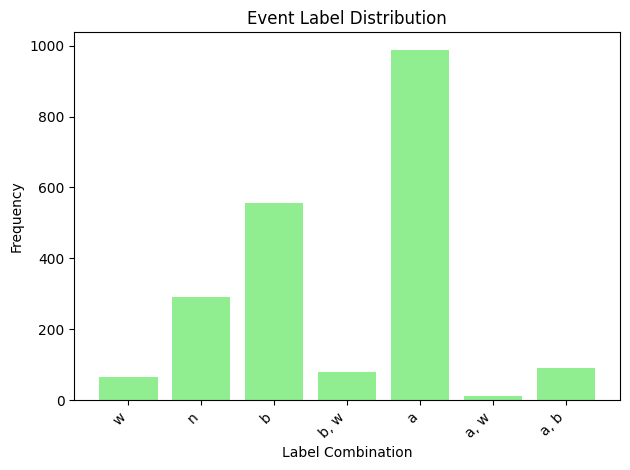

In [ ]:
# list of possible labels
label_names = ['a', 'b', 'n', 'w']

# unique combinations of labels and their frequencies
unique_combos, frequencies = np.unique(Y, axis=0, return_counts=True)


label_descriptions = []
for combo in unique_combos:
    active = [label_names[idx] for idx, is_active in enumerate(combo) if is_active]
    label_descriptions.append(", ".join(active) if active else "No Label")


plt.bar(label_descriptions, frequencies, color='lightgreen')
plt.title("Event Label Distribution")
plt.xlabel("Label Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
save_pickle('labels',Y)

In [ ]:
labels = load_pickle('labels')

In [ ]:
# Convert the audio segments into spectrograms

def compute_spectrograms(audio_segments, sample_rate=downsample_rate, fft_window=n_fft, hop_step=hop_length, mel_bins=n_mels):
    result_spectrograms = []

    for segment in audio_segments:
        mel_spectrogram = librosa.feature.melspectrogram(
            y=segment, sr=sample_rate, n_fft=fft_window, hop_length=hop_step, n_mels=mel_bins
        )
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = (mel_spectrogram_db - np.min(mel_spectrogram_db)) / (np.max(mel_spectrogram_db) - np.min(mel_spectrogram_db))
        mel_spectrogram_db = mel_spectrogram_db.astype(np.float32)
        result_spectrograms.append(mel_spectrogram_db)

    return np.array(result_spectrograms)

# Apply the function to the audio data
spectrograms = compute_spectrograms(X)

In [ ]:
# Save to pickle file

save_pickle('spectrograms', spectrograms)

In [ ]:
# Load from pickle file to save time (next time you run the script)

spectrograms = compute_spectrograms(X)

In [ ]:
# print the shapes of the spectrograms and targets

spectrograms.shape


(2083, 128, 79)

In [ ]:
# Save to pickle file

save_pickle('spectrograms', spectrograms)

In [ ]:
save_pickle('labels',Yx)

In [ ]:
labels = load_pickle('Y')

In [ ]:
# Load from pickle file to save time (next time you run the script)

trainable_specs = load_pickle('spectrograms')
trainable_labels = load_pickle('labels')

In [ ]:
# print the shapes of the spectrograms and targets
trainable_specs.shape

(2083, 128, 79)

In [ ]:
# once you have spectrograms, you might want to delete  some old variables to save some RAM
# I'll only mention this hint once.

del X,Y

In [ ]:
# Train and val splitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(spectrograms, Y, test_size=0.2, random_state=42)

In [ ]:
# print shapes of training and validation data

print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(1666, 128, 79)
(417, 128, 79)
(1666, 4)
(417, 4)


In [ ]:
import numpy as np

def augment_data(data, noise_factor=0.03):

    augmented_data = np.copy(data)


    if np.random.choice([True, False]):
        noise = np.random.normal(0, 1, augmented_data.shape)
        augmented_data += noise_factor * noise


    if np.random.choice([True, False]):
        square_mask = np.random.rand(*augmented_data.shape) < 0.1
        augmented_data[square_mask] = augmented_data[square_mask] ** 2


    if np.random.choice([True, False]):
        removal_mask = np.random.rand(*augmented_data.shape) < 0.05
        augmented_data[removal_mask] = 0

    return augmented_data


In [ ]:
def augment_per_event(x_train, y_train, target_count=800):
    # Identify unique events and their counts
    unique_events, counts = np.unique(y_train, axis=0, return_counts=True)

    augmented_spectrograms = []
    augmented_targets = []

    for unique_event, count in zip(unique_events, counts):
        if count < target_count:
            no_to_augment = target_count - count
            matching_indices = np.where((y_train == unique_event).all(axis=1))[0]


            num_augmentations_per_sample = no_to_augment // len(matching_indices)
            extra = no_to_augment % len(matching_indices)

            for idx in matching_indices:
                augmented_samples = augment_data(
                    np.repeat(x_train[idx][np.newaxis, :], num_augmentations_per_sample, axis=0)
                )
                augmented_spectrograms.extend(augmented_samples)
                augmented_targets.extend([unique_event] * num_augmentations_per_sample)


            for idx in matching_indices[:extra]:
                augmented_samples = augment_data(x_train[idx][np.newaxis, :])
                augmented_spectrograms.extend(augmented_samples)
                augmented_targets.extend([unique_event])


    x_combined = np.concatenate([x_train, np.array(augmented_spectrograms)], axis=0)
    y_combined = np.concatenate([y_train, np.array(augmented_targets)], axis=0)

    return x_combined, y_combined


In [ ]:
X_train_combined, Y_train_combined = augment_per_event(X_train, Y_train)

In [ ]:
print(X_train_combined.shape)
print(Y_train_combined.shape)
print(X_val.shape)
print(Y_val.shape)

(5601, 128, 79)
(5601, 4)
(417, 128, 79)
(417, 4)


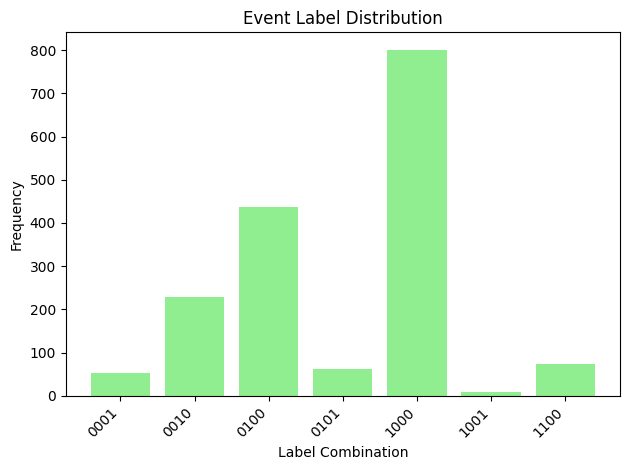

In [ ]:
# View the amount of training/validation data and their distributions
import matplotlib.pyplot as plt
unique_combos, frequencies = np.unique(Y_train, axis=0, return_counts=True)
unique_combos_str = ["".join(map(str,map(int,label))) for label in unique_combos]
plt.bar(unique_combos_str, frequencies, color='lightgreen')
plt.title("Event Label Distribution")
plt.xlabel("Label Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


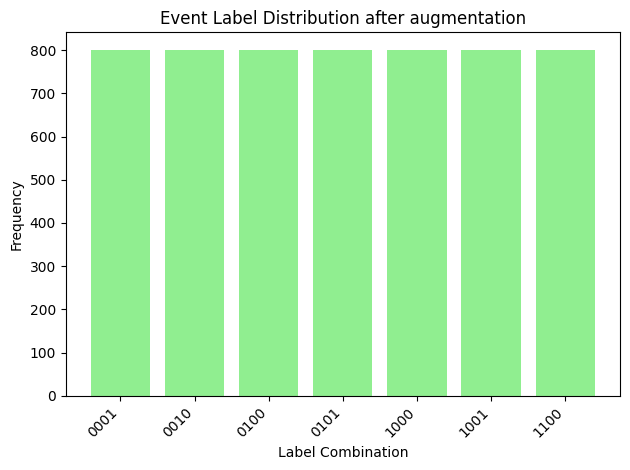

In [ ]:
# View the amount of training/validation data and their distributions
import matplotlib.pyplot as plt
unique_combos, frequencies = np.unique(Y_train_combined, axis=0, return_counts=True)
unique_combos_str = ["".join(map(str,map(int,label))) for label in unique_combos]
plt.bar(unique_combos_str, frequencies, color='lightgreen')
plt.title("Event Label Distribution after augmentation")
plt.xlabel("Label Combination")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

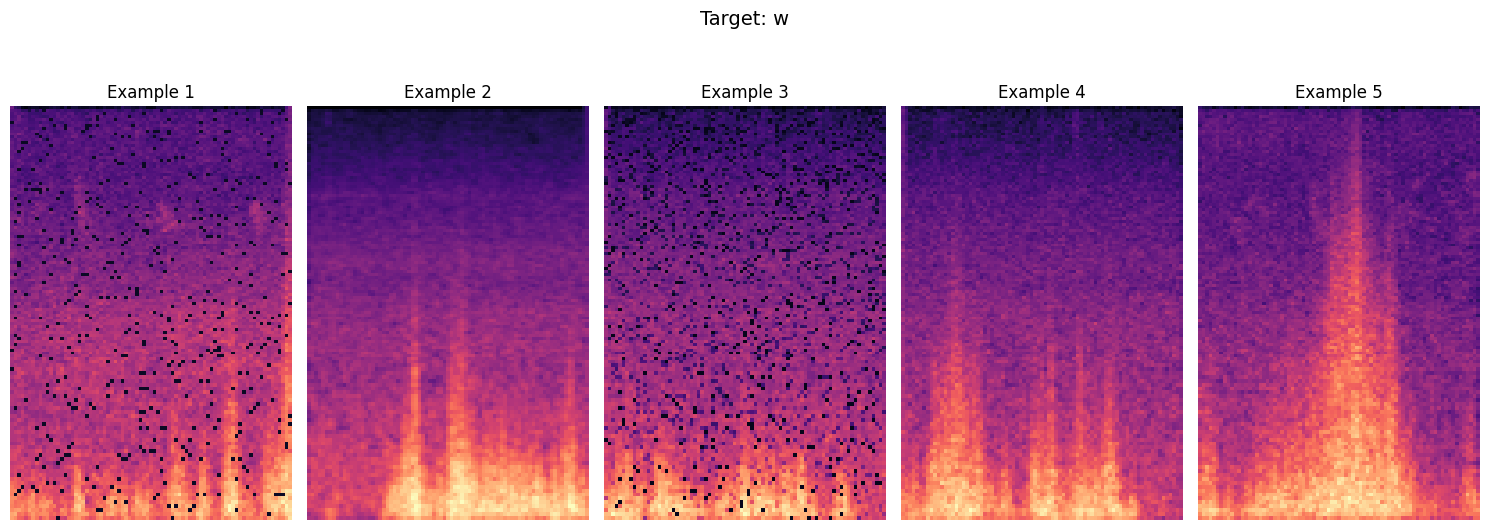

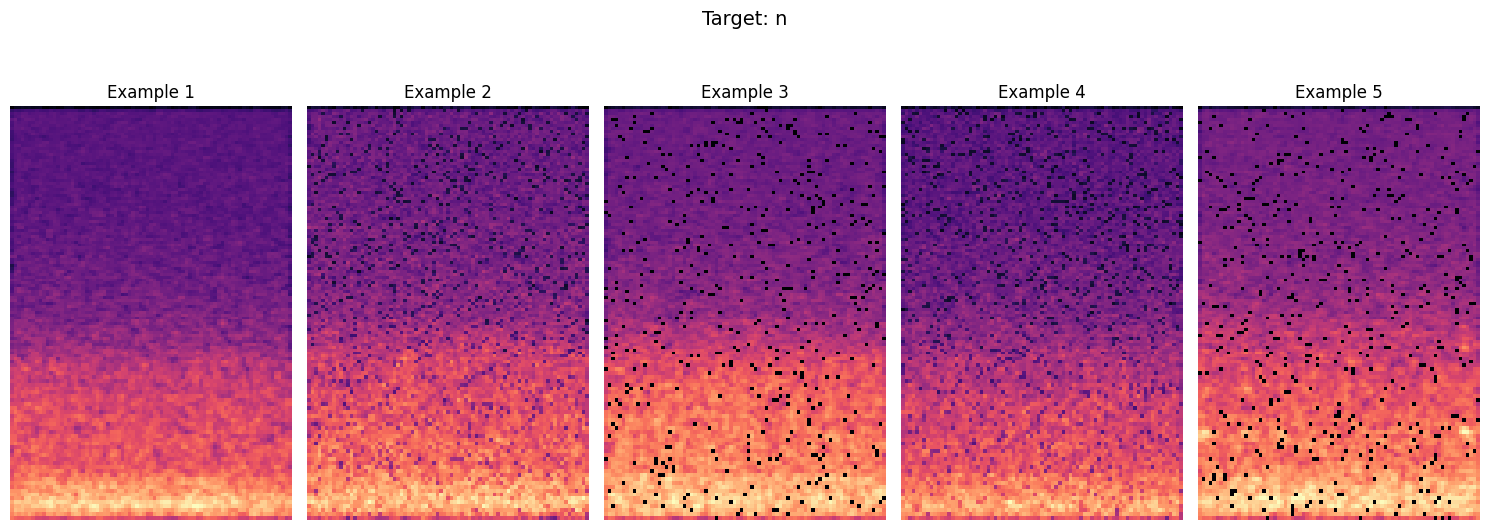

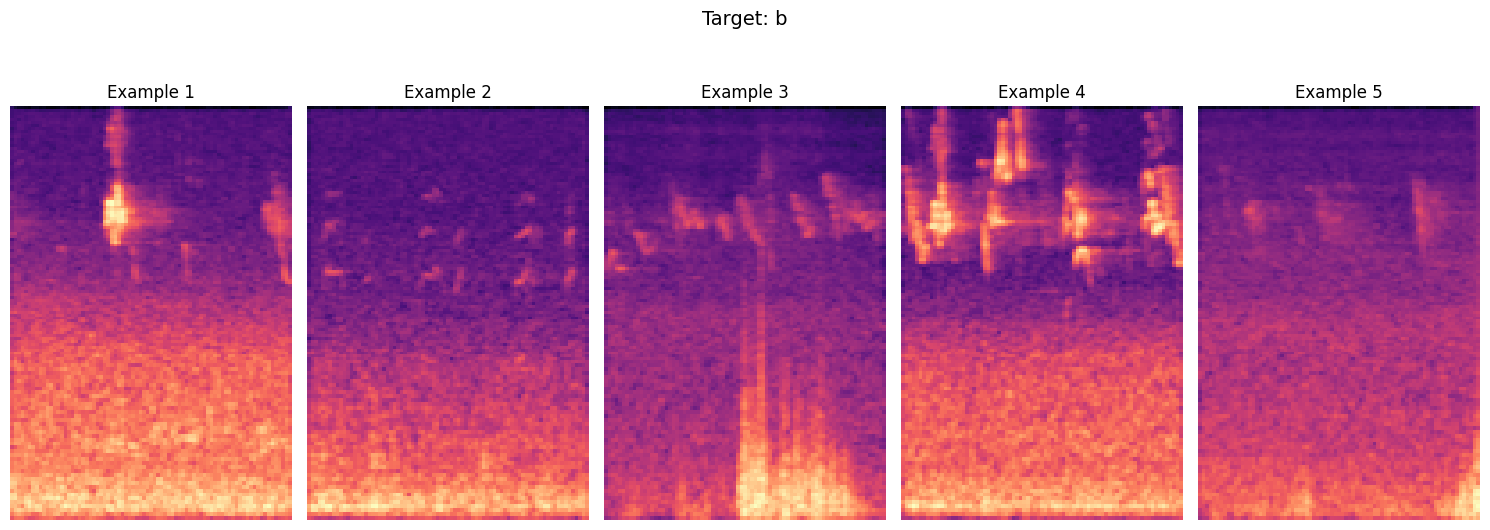

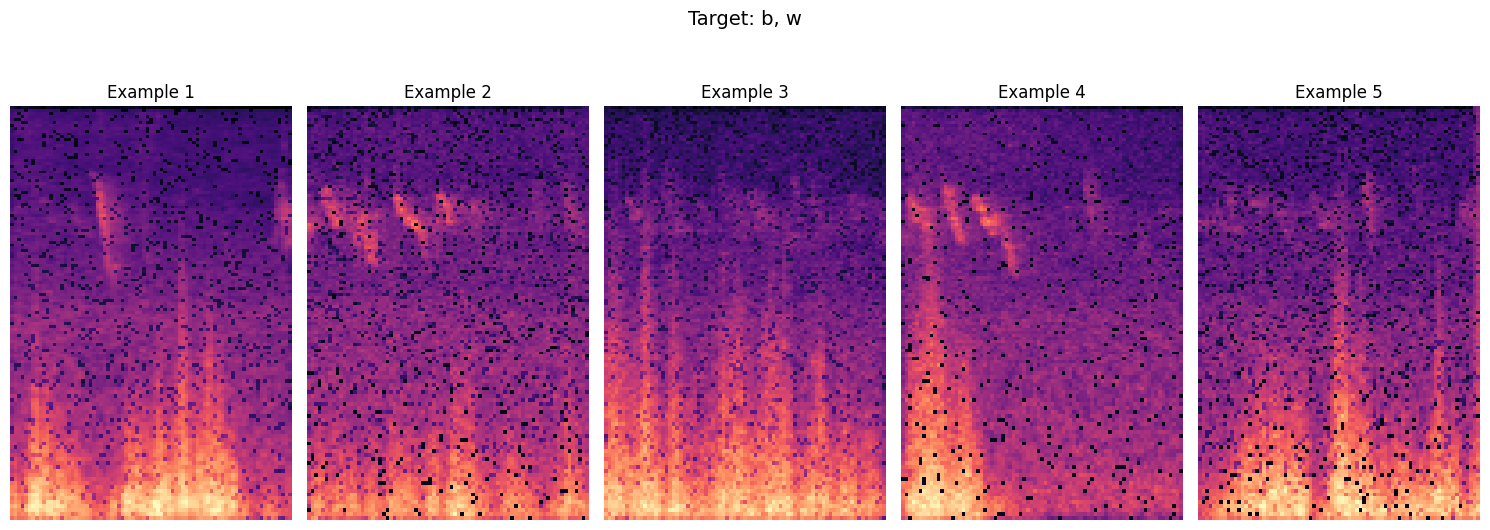

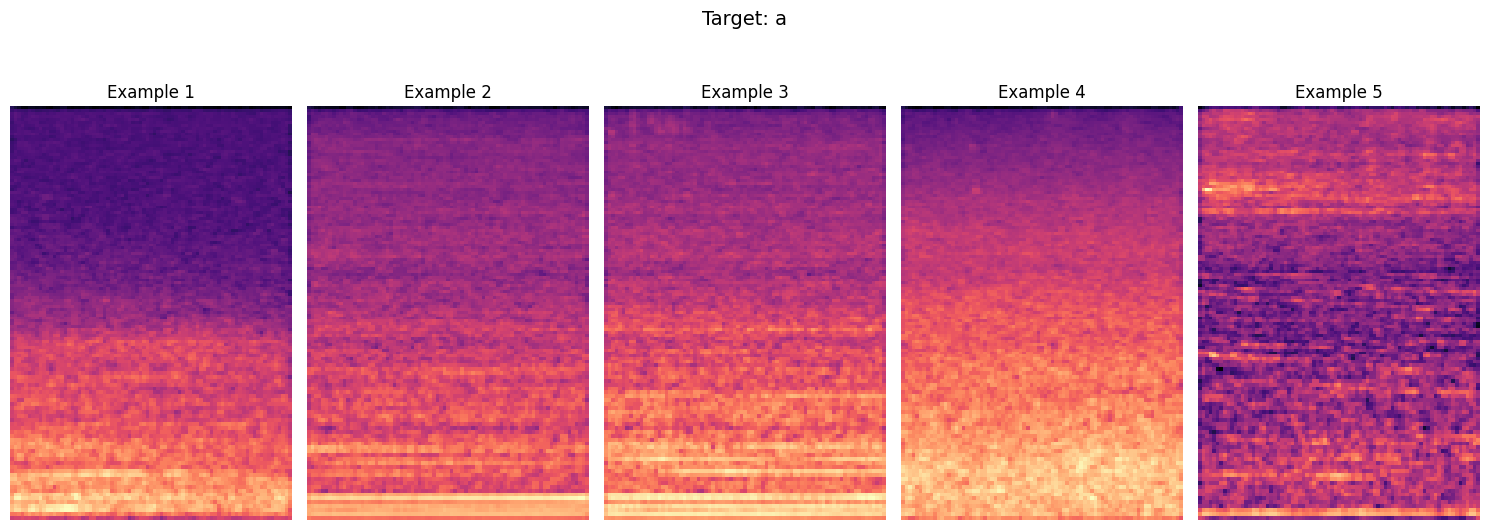

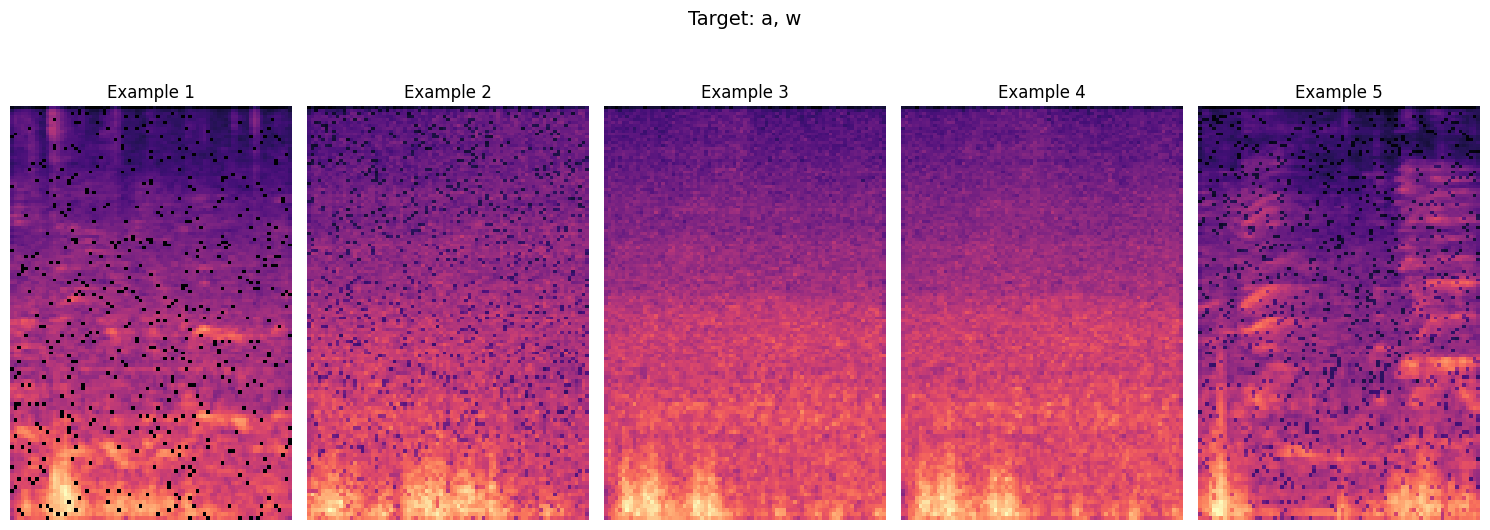

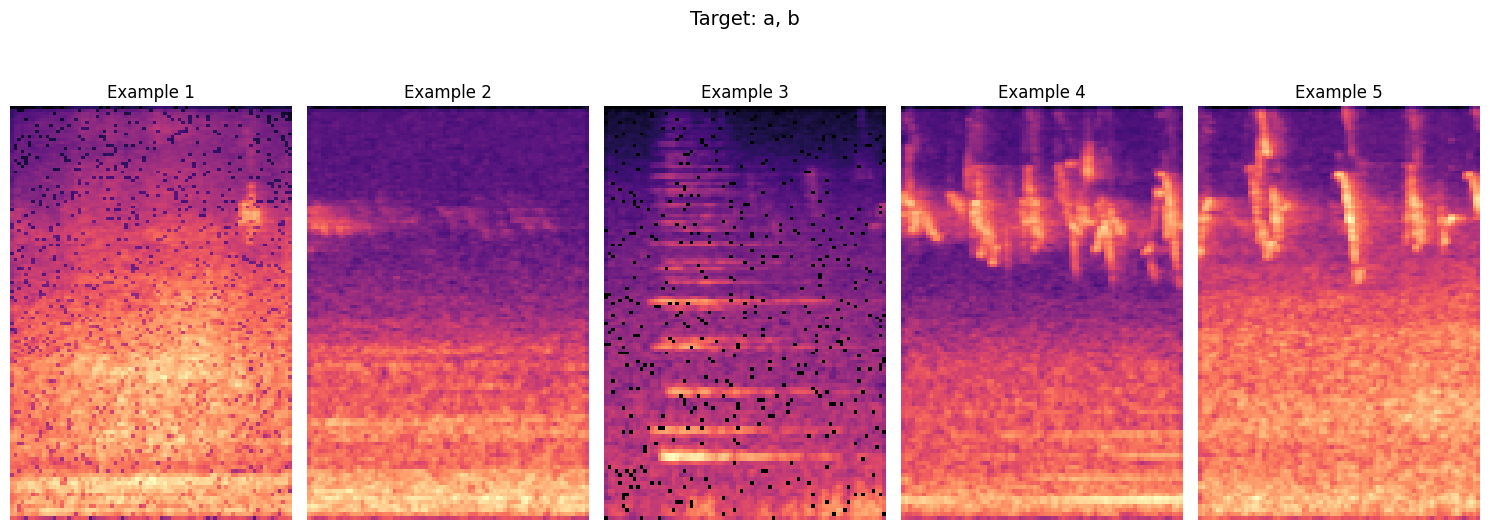

In [ ]:
# Display 5 spectrogram examples of each of the different types of targets
# in each case view the spectrogram and display the target. Note that some
# events are multi-label, so you need to show 5 examples for each different
# multi/single event

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import librosa.display

def display_spectrograms(X, Y, label_names, num_examples=5):


    unique_targets = np.unique(Y, axis=0)

    for target in unique_targets:

        target_indices = np.where((Y == target).all(axis=1))[0]
        np.random.shuffle(target_indices)
        target_indices = target_indices[:num_examples]


        target_labels = [label_names[idx] for idx, val in enumerate(target) if val == 1]
        target_description = ", ".join(target_labels) if target_labels else "No Label"

        # Plot the spectrograms
        fig, axes = plt.subplots(1, len(target_indices), figsize=(15, 5))
        fig.suptitle(f"Target: {target_description}", fontsize=14, y=1.05)

        for i, idx in enumerate(target_indices):
            librosa.display.specshow(X[idx], sr=downsample_rate, x_axis='time', y_axis='mel', ax=axes[i])
            axes[i].set_title(f"Example {i + 1}")
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

label_names = ['a', 'b', 'n', 'w']
display_spectrograms(X_train_combined, Y_train_combined, label_names, num_examples=5)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 79 , 1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 77, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 36, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 6, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,696,900 (10.29 MB)

 Trainable params: 2,696,900 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="best_model1.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), callbacks=callbacks_list, epochs = 10, batch_size=32)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5133 - loss: 0.5667
Epoch 1: val_loss improved from inf to 0.47798, saving model to best_model1.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5136 - loss: 0.5657 - val_accuracy: 0.4964 - val_loss: 0.4780
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.5286 - loss: 0.4769
Epoch 2: val_loss improved from 0.47798 to 0.44419, saving model to best_model1.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.5290 - loss: 0.4766 - val_accuracy: 0.5276 - val_loss: 0.4442
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5924 - loss: 0.4189
Epoch 3: val_loss improved from 0.44419 to 0.34396, saving model to best_model1.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5932 - loss: 0.4185 - val_accuracy: 0.7770 - val_loss: 0.3440
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7379 - loss: 0.3348
Epoch 4: val_loss improved from 0.34396 to 0.28413, saving model t

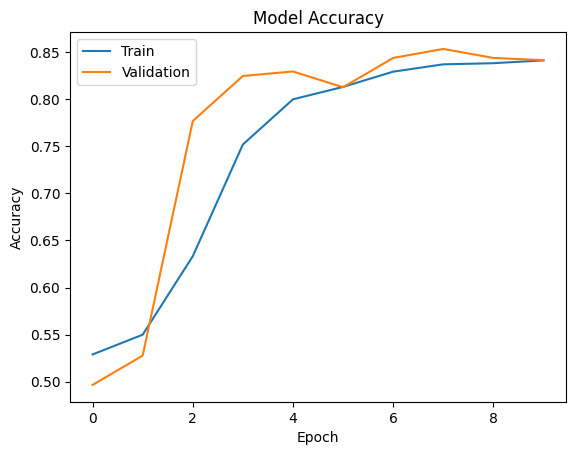

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('model_accuracy.pdf')
plt.show()

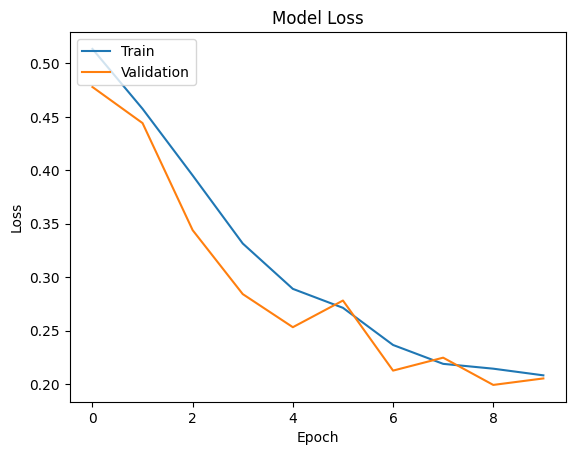

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig('model_loss.pdf')
plt.legend(['Train', 'Validation'], loc='upper left')

In [ ]:
model.load_weights('/content/drive/MyDrive/DL4E/model13.weights.h5')

In [ ]:
# Write a function that takes in timestamps and groups the predicted
# events together. For example, if your model things that seconds
# 0,1,2,3 are all events of type [0,0,1,1] then group them togeter

import pandas as pd

def group_predicted_events(timestamps, predictions, threshold=0.5):

    events = []
    current_event = {"start": None, "end": None, "labels": []}

    for i, (time, pred) in enumerate(zip(timestamps, predictions)):
        active_labels = [j for j, val in enumerate(pred) if val >= threshold]

        if active_labels:
            if current_event["start"] is None:
                current_event["start"] = time
                current_event["labels"] = active_labels
            current_event["end"] = time
        else:
            if current_event["start"] is not None:
                events.append(current_event)
                current_event = {"start": None, "end": None, "labels": []}

    # Add the last event if active
    if current_event["start"] is not None:
        events.append(current_event)

    return pd.DataFrame(events)


In [ ]:
# write a function that takes your model and predicts on a single test file
# use this function signature:  def predict_single_file(test_file_name, test_path, model):
# this function should produce a plot, showing time on the x-axis, and it should
# inform the person viewing the plot as to what types of acoustic events occured
# during that time. The plot should be as informative as possible so someone
# will know what happened during this file

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def predict_single_file(test_file_name, test_path, model):


    pred = []
    segments = []
    original_preds = []

    audio, sr = librosa.load(f"{test_path}/{test_file_name}", sr=None)
    duration = int(len(audio) / downsample_rate)
    class_labels = [[] for _ in range(duration)]
    predicted_classes = []


    for i in range(0, duration):
        sc = i
        es = i + 2
        if es > duration:
            break

        # Extract a mel spectrogram for the segment
        segment_audio = audio[sc * sr : sr * es]
        if len(segment_audio) == 0:
            continue

        spectrogram = librosa.feature.melspectrogram(
            y=segment_audio, sr=downsample_rate, n_fft=2048, hop_length=512, n_mels=128
        )
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

        sp = np.resize(spectrogram_db, (128, 79, 1))
        spectrogram_db = np.expand_dims(sp, axis=-1)
        spectrogram_input = np.expand_dims(spectrogram_db, axis=0)
        sp = spectrogram_input

        segments.append((sc, es))

        predictions = model.predict(sp, verbose=False)
        binary_predictions = [1 if p > 0.5 else 0 for p in predictions[0]]

        pred.append(binary_predictions)
        original_preds.append(predictions[0])

        if check_elem(binary_predictions):
            class_labels[i].append(label_names[np.argmax(predictions)])

        else:
          if binary_predictions[0] == 1:
            class_labels[i].append('a')
          if binary_predictions[1] == 1:
              class_labels[i].append('b')
          if binary_predictions[2] == 1:
              class_labels[i].append('n')
          if binary_predictions[3] == 1:
              class_labels[i].append('w')

        predicted_classes.append(class_labels[i])

    for i, (segment, segment_classes) in enumerate(zip(segments, predicted_classes)):
        segment_classes_flat = [cls for sublist in segment_classes for cls in (sublist if isinstance(sublist, list) else [sublist])]
        print(f"Segment {i + 1}: {segment[0]}s - {segment[1]}s -> Predicted Classes: {', '.join(segment_classes_flat)}")

    return pred, segments, predicted_classes, class_labels, original_preds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from matplotlib.patches import Rectangle
import seaborn as sns
import matplotlib.ticker as ticker


def predict_and_plot(test_file_name, test_path, model, label_names,predict_single_file, downsample_rate=downsample_rate):


    pred, segments, predicted_classes, class_labels, original_preds = predict_single_file



    audio, sr = librosa.load(f"{test_path}/{test_file_name}", sr=None)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=downsample_rate, n_fft=2048, hop_length=512, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)


    grouped_events = []
    for i, (segment, classes) in enumerate(zip(segments, predicted_classes)):
        if classes:
            grouped_events.append({
                'start_time': segment[0],
                'end_time': segment[1],
                'event_type': classes
            })


    plot_prediction(audio, sr, grouped_events, mel_spec_db, test_file_name)


def plot_prediction(audio, sr, grouped_events, mel_spec_db, test_file_name):


    unique_labels = sorted(
        set(",".join(sorted(event['event_type'])) for event in grouped_events)
    )


    colors = sns.color_palette('husl', n_colors=len(unique_labels))
    color_map = {label: colors[idx] for idx, label in enumerate(unique_labels)}


    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), height_ratios=[2, 1])
    fig.suptitle(f'Acoustic Event Analysis: {test_file_name}', fontsize=14)


    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', ax=ax1)
    ax1.set_title('Mel Spectrogram with Detected Events')

    legend_elements = []
    for event in grouped_events:
        label = ",".join(sorted(event['event_type']))
        color = color_map[label]
        rect = Rectangle(
            (event['start_time'], 0),
            event['end_time'] - event['start_time'],
            ax1.get_ylim()[1],
            alpha=0.3,
            color=color
        )
        ax1.add_patch(rect)
        if label not in [e.get_label() for e in legend_elements]:
            legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=label))

    ax1.legend(handles=legend_elements, loc='upper right')


    ax2.set_xlim(0, len(audio) / sr)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_title('Event Timeline')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_yticks([])

    for event in grouped_events:
        label = ",".join(sorted(event['event_type']))
        color = color_map[label]
        ax2.plot(
            [event['start_time'], event['end_time']],
            [0, 0],
            linewidth=10,
            color=color,
            solid_capstyle='butt'
        )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
def check_elem(list_):
  counter = 0
  for elem in list_:
    if elem == 1:
      counter += 1
  if counter > 1:
    return False
  else:
    return True

In [ ]:
from collections import Counter
def label_dist(labels):


    label_strings = [",".join(sorted(label)) if isinstance(label, list) else label for label in labels]


    label_counter = Counter(label_strings)


    unique_labels, counts = zip(*label_counter.items())
    unique_labels, counts
    plot_label_dist(unique_labels, counts)

def plot_label_dist(labels, counts):
    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.title('Distribution of Targets')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [ ]:
# do not modify
test3 = '1APBxL5lyAX_cV0U5BLkz3BSrhUKm7zaB'
test4 = '1ROfjh47uZtnK-HVNiwcbAECC6HIwYtmk'
test5 = '144H3yHYIxHH6v_JY_-EP2--X5U7PxwbX'
test6 = '1I_GeHEt0EdoAptUjh9obDOoXXNUm1Rwq'
test7 = '1AdLXsvvbgSPSI6IrvDY0cSDIpccbtx4B'
test8 = '1nKdVkDEV4v8RTONoPQR0xiepc6B6_JSi'
test9 = '13k_o2W62I9aQRWmubT-U5-lQcRm4w6oi'
test10 = '1z-60L-piAo96URDKpfY7jW3V0UWiHfAt'

In [ ]:
# do not modify
downloaded = drive.CreateFile({'id':test3})
downloaded.GetContentFile('20241113_102700_AIMS.WAV')

downloaded = drive.CreateFile({'id':test4})
downloaded.GetContentFile('20241113_092100_AIMS.WAV')

downloaded = drive.CreateFile({'id':test5})
downloaded.GetContentFile('20241113_022700_CC.WAV')

downloaded = drive.CreateFile({'id':test6})
downloaded.GetContentFile('20241112_061800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test7})
downloaded.GetContentFile('20241112_035100.WAV')

downloaded = drive.CreateFile({'id':test8})
downloaded.GetContentFile('20241112_024800.WAV')

downloaded = drive.CreateFile({'id':test9})
downloaded.GetContentFile('20241112_024800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test10})
downloaded.GetContentFile('20241111_224500.WAV')

Predict on these files. You will be assessed on how well your model performs on these files and how informative your plot was at telling a story about what sounds happened in this file.

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241111_224500.WAV'
pred, segments, predicted_classes, class_labels, original_preds= predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: n
Segment 2: 1s - 3s -> Predicted Classes: n
Segment 3: 2s - 4s -> Predicted Classes: n
Segment 4: 3s - 5s -> Predicted Classes: a, n
Segment 5: 4s - 6s -> Predicted Classes: n
Segment 6: 5s - 7s -> Predicted Classes: n
Segment 7: 6s - 8s -> Predicted Classes: n
Segment 8: 7s - 9s -> Predicted Classes: a, n
Segment 9: 8s - 10s -> Predicted Classes: n
Segment 10: 9s - 11s -> Predicted Classes: n
Segment 11: 10s - 12s -> Predicted Classes: n
Segment 12: 11s - 13s -> Predicted Classes: n
Segment 13: 12s - 14s -> Predicted Classes: a
Segment 14: 13s - 15s -> Predicted Classes: a
Segment 15: 14s - 16s -> Predicted Classes: a, n
Segment 16: 15s - 17s -> Predicted Classes: a
Segment 17: 16s - 18s -> Predicted Classes: a
Segment 18: 17s - 19s -> Predicted Classes: a
Segment 19: 18s - 20s -> Predicted Classes: a
Segment 20: 19s - 21s -> Predicted Classes: a
Segment 21: 20s - 22s -> Predicted Classes: a
Segment 22: 21s - 23s -> Predicted Classes: n
Segmen

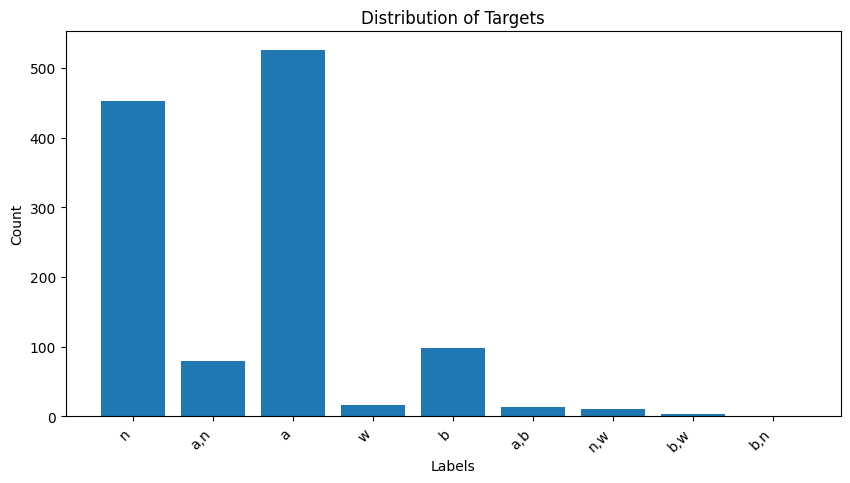

In [ ]:
label_dist(predicted_classes)

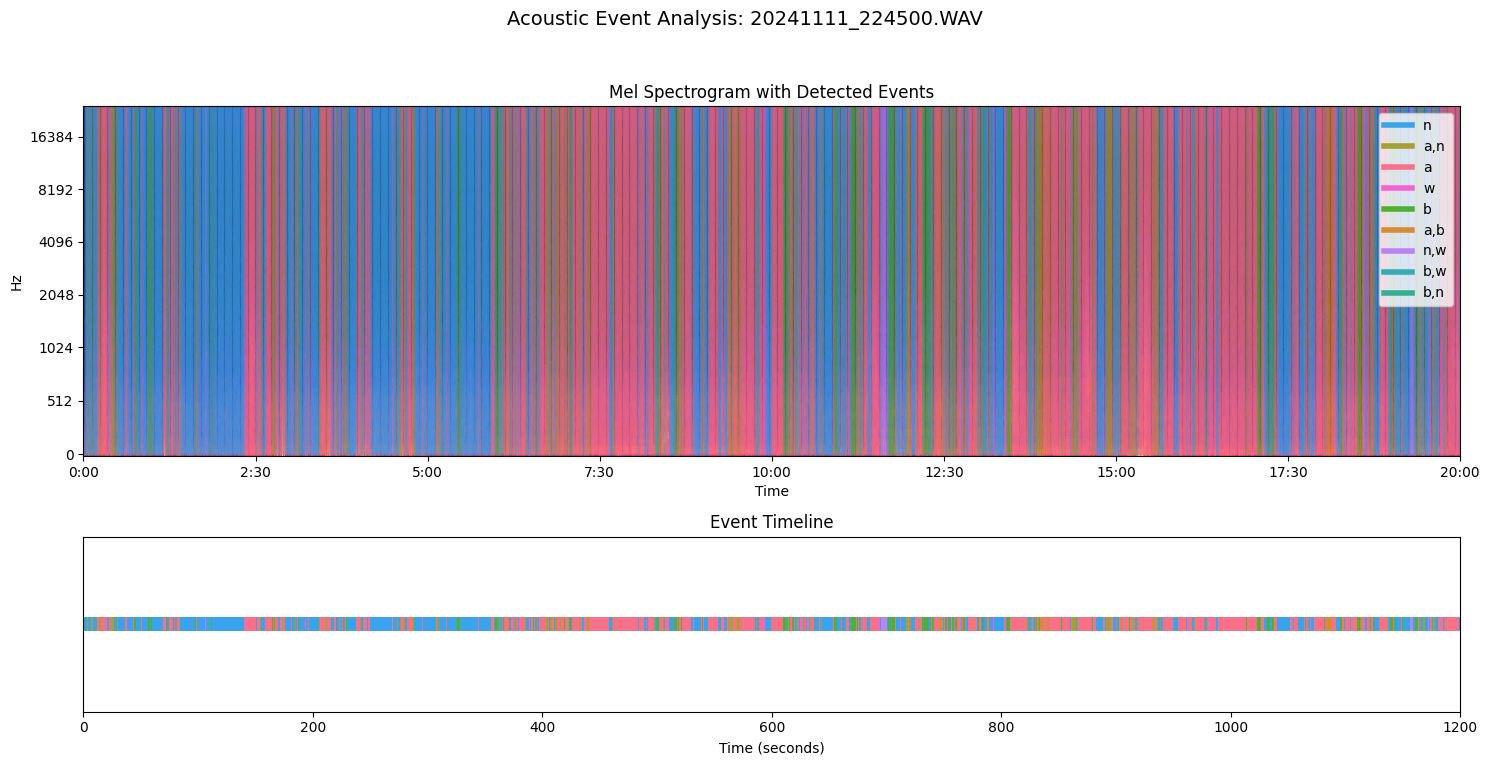

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: b, n
Segment 2: 1s - 3s -> Predicted Classes: b
Segment 3: 2s - 4s -> Predicted Classes: n
Segment 4: 3s - 5s -> Predicted Classes: b, n
Segment 5: 4s - 6s -> Predicted Classes: b, n
Segment 6: 5s - 7s -> Predicted Classes: n
Segment 7: 6s - 8s -> Predicted Classes: b, n
Segment 8: 7s - 9s -> Predicted Classes: n
Segment 9: 8s - 10s -> Predicted Classes: n
Segment 10: 9s - 11s -> Predicted Classes: b, n
Segment 11: 10s - 12s -> Predicted Classes: n
Segment 12: 11s - 13s -> Predicted Classes: a, n
Segment 13: 12s - 14s -> Predicted Classes: a, n
Segment 14: 13s - 15s -> Predicted Classes: a, n
Segment 15: 14s - 16s -> Predicted Classes: n
Segment 16: 15s - 17s -> Predicted Classes: b, n
Segment 17: 16s - 18s -> Predicted Classes: n
Segment 18: 17s - 19s -> Predicted Classes: n
Segment 19: 18s - 20s -> Predicted Classes: n
Segment 20: 19s - 21s -> Predicted Classes: n
Segment 21: 20s - 22s -> Predicted Classes: n
Segment 22: 21s - 23s -> Predicted

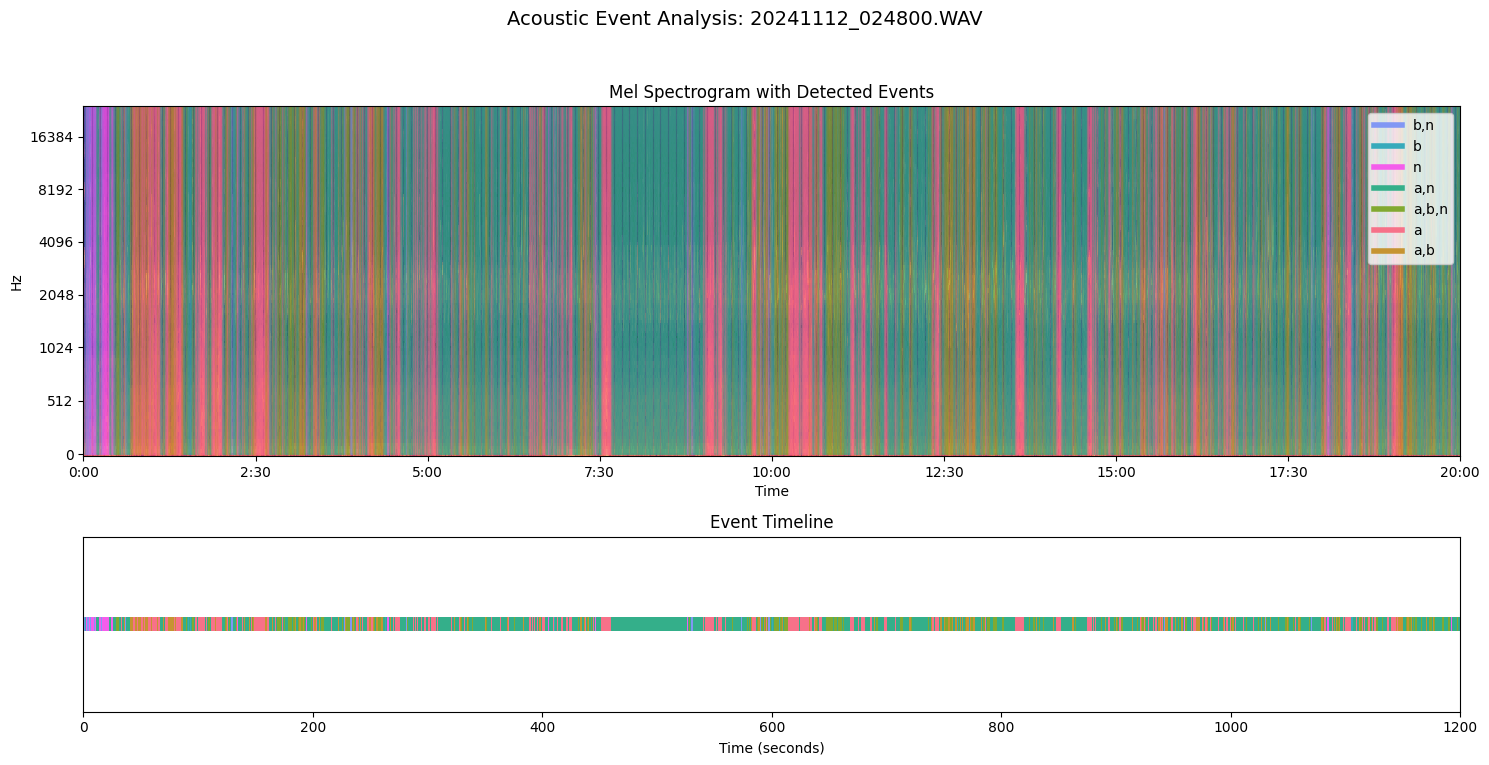

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800_AIMS.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: b, n
Segment 2: 1s - 3s -> Predicted Classes: n
Segment 3: 2s - 4s -> Predicted Classes: n
Segment 4: 3s - 5s -> Predicted Classes: b
Segment 5: 4s - 6s -> Predicted Classes: b, n, w
Segment 6: 5s - 7s -> Predicted Classes: n, w
Segment 7: 6s - 8s -> Predicted Classes: n, w
Segment 8: 7s - 9s -> Predicted Classes: b, n
Segment 9: 8s - 10s -> Predicted Classes: n
Segment 10: 9s - 11s -> Predicted Classes: b
Segment 11: 10s - 12s -> Predicted Classes: b
Segment 12: 11s - 13s -> Predicted Classes: b
Segment 13: 12s - 14s -> Predicted Classes: n, w
Segment 14: 13s - 15s -> Predicted Classes: n, w
Segment 15: 14s - 16s -> Predicted Classes: n, w
Segment 16: 15s - 17s -> Predicted Classes: n
Segment 17: 16s - 18s -> Predicted Classes: n
Segment 18: 17s - 19s -> Predicted Classes: n
Segment 19: 18s - 20s -> Predicted Classes: n
Segment 20: 19s - 21s -> Predicted Classes: b, n
Segment 21: 20s - 22s -> Predicted Classes: n
Segment 22: 21s - 23s -> Predic

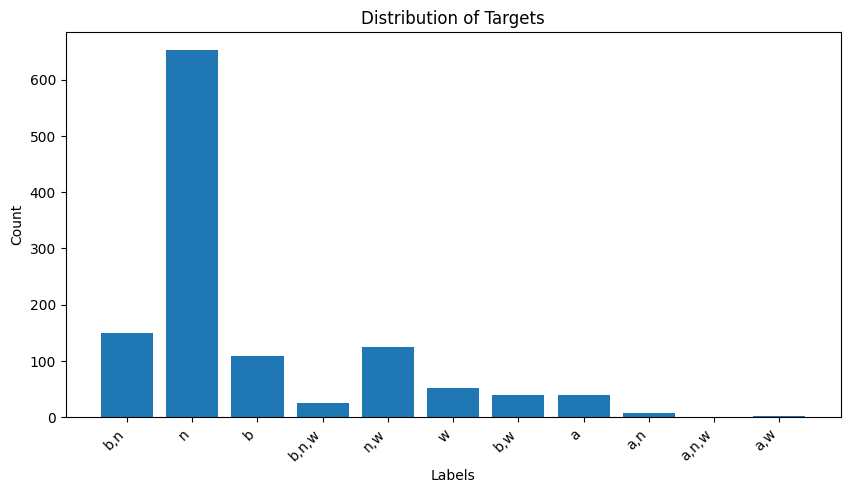

In [ ]:
label_dist(predicted_classes)

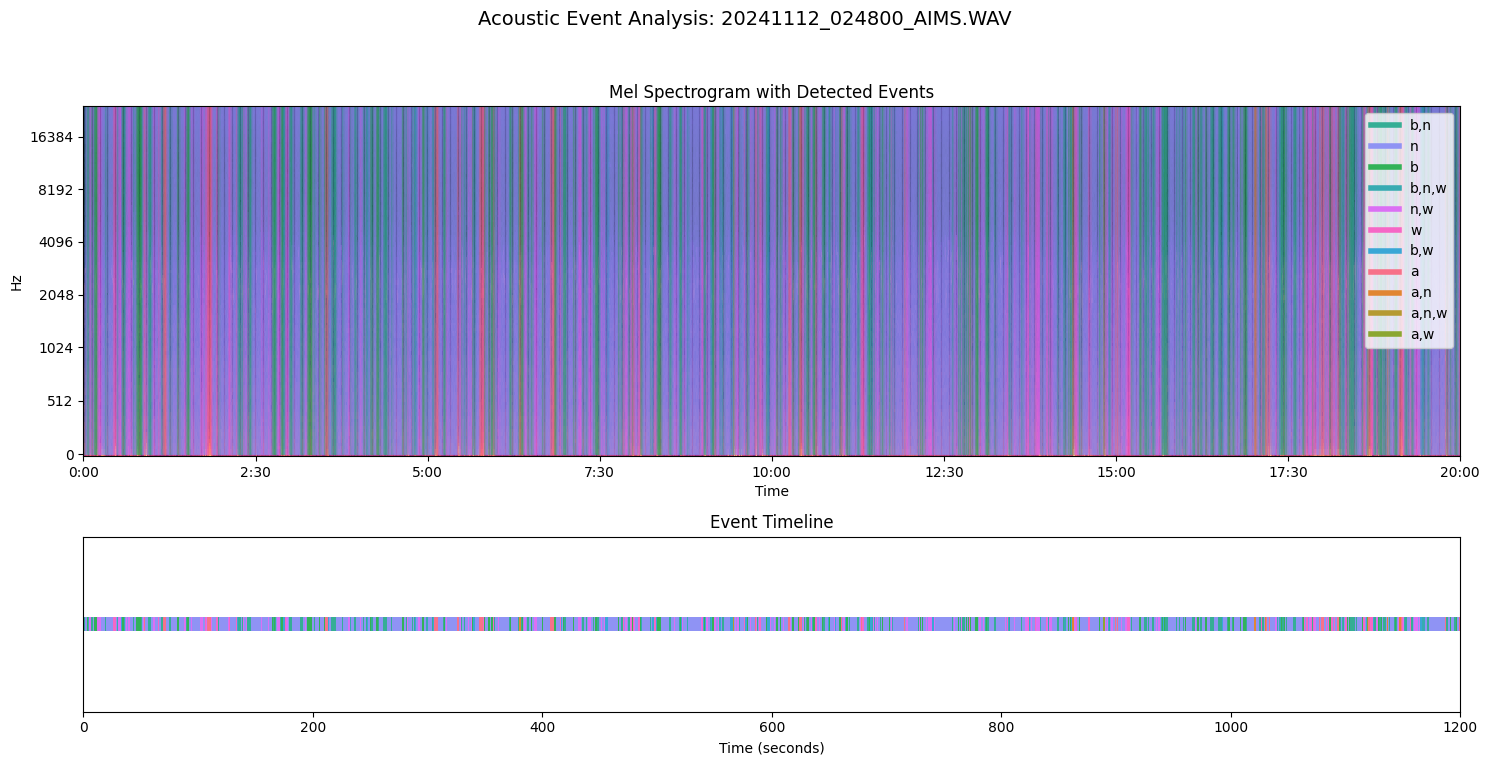

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241112_061800_AIMS.WAV'

pred, segments, predicted_classes, class_labels, original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: n
Segment 2: 1s - 3s -> Predicted Classes: n
Segment 3: 2s - 4s -> Predicted Classes: n
Segment 4: 3s - 5s -> Predicted Classes: n
Segment 5: 4s - 6s -> Predicted Classes: n
Segment 6: 5s - 7s -> Predicted Classes: n
Segment 7: 6s - 8s -> Predicted Classes: n
Segment 8: 7s - 9s -> Predicted Classes: b, n
Segment 9: 8s - 10s -> Predicted Classes: b, n
Segment 10: 9s - 11s -> Predicted Classes: n
Segment 11: 10s - 12s -> Predicted Classes: w
Segment 12: 11s - 13s -> Predicted Classes: b, n
Segment 13: 12s - 14s -> Predicted Classes: n
Segment 14: 13s - 15s -> Predicted Classes: b
Segment 15: 14s - 16s -> Predicted Classes: n
Segment 16: 15s - 17s -> Predicted Classes: n
Segment 17: 16s - 18s -> Predicted Classes: n
Segment 18: 17s - 19s -> Predicted Classes: a, n
Segment 19: 18s - 20s -> Predicted Classes: n, w
Segment 20: 19s - 21s -> Predicted Classes: n
Segment 21: 20s - 22s -> Predicted Classes: n
Segment 22: 21s - 23s -> Predicted Classes: n


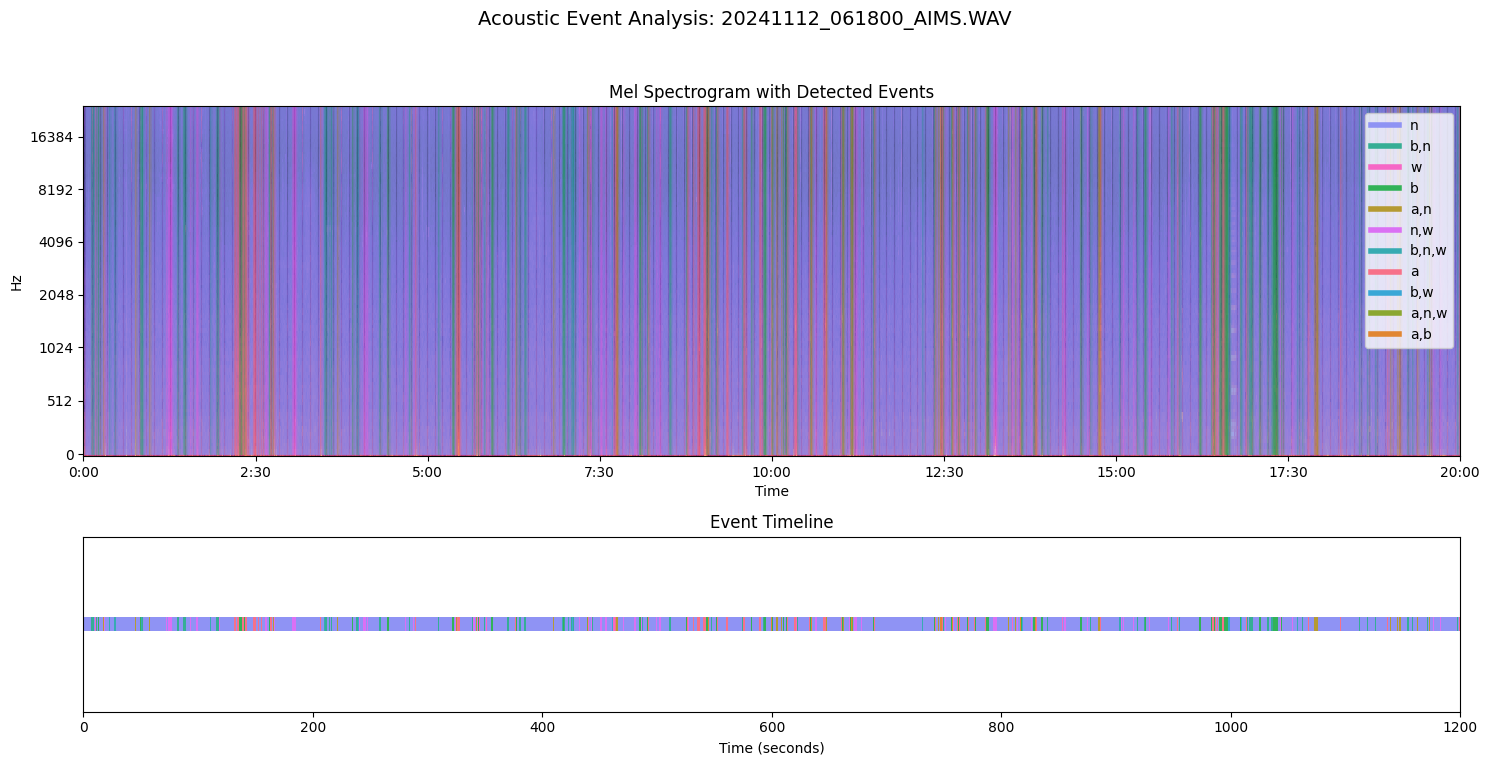

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241112_035100.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: n
Segment 2: 1s - 3s -> Predicted Classes: n
Segment 3: 2s - 4s -> Predicted Classes: a
Segment 4: 3s - 5s -> Predicted Classes: a, n
Segment 5: 4s - 6s -> Predicted Classes: a, n
Segment 6: 5s - 7s -> Predicted Classes: a, n
Segment 7: 6s - 8s -> Predicted Classes: n
Segment 8: 7s - 9s -> Predicted Classes: a
Segment 9: 8s - 10s -> Predicted Classes: a
Segment 10: 9s - 11s -> Predicted Classes: n
Segment 11: 10s - 12s -> Predicted Classes: a
Segment 12: 11s - 13s -> Predicted Classes: n
Segment 13: 12s - 14s -> Predicted Classes: a
Segment 14: 13s - 15s -> Predicted Classes: a, n
Segment 15: 14s - 16s -> Predicted Classes: n
Segment 16: 15s - 17s -> Predicted Classes: a
Segment 17: 16s - 18s -> Predicted Classes: a
Segment 18: 17s - 19s -> Predicted Classes: a
Segment 19: 18s - 20s -> Predicted Classes: b
Segment 20: 19s - 21s -> Predicted Classes: n
Segment 21: 20s - 22s -> Predicted Classes: n
Segment 22: 21s - 23s -> Predicted Classes: a
Seg

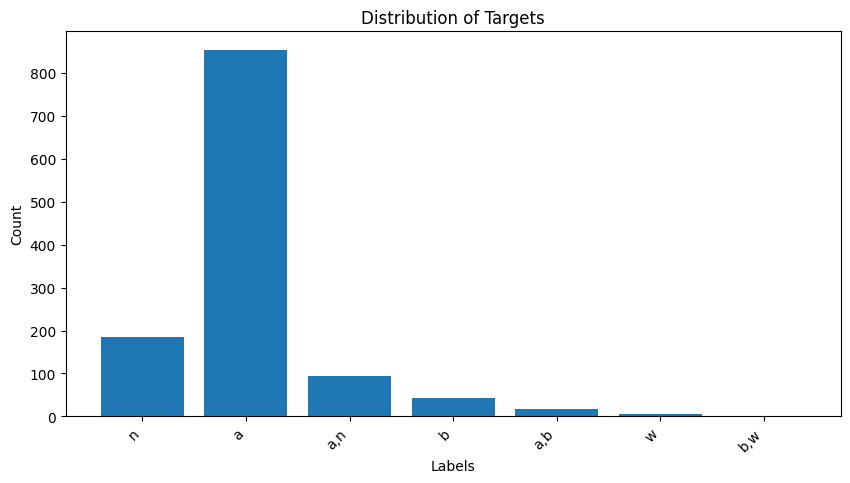

In [ ]:
label_dist(predicted_classes)

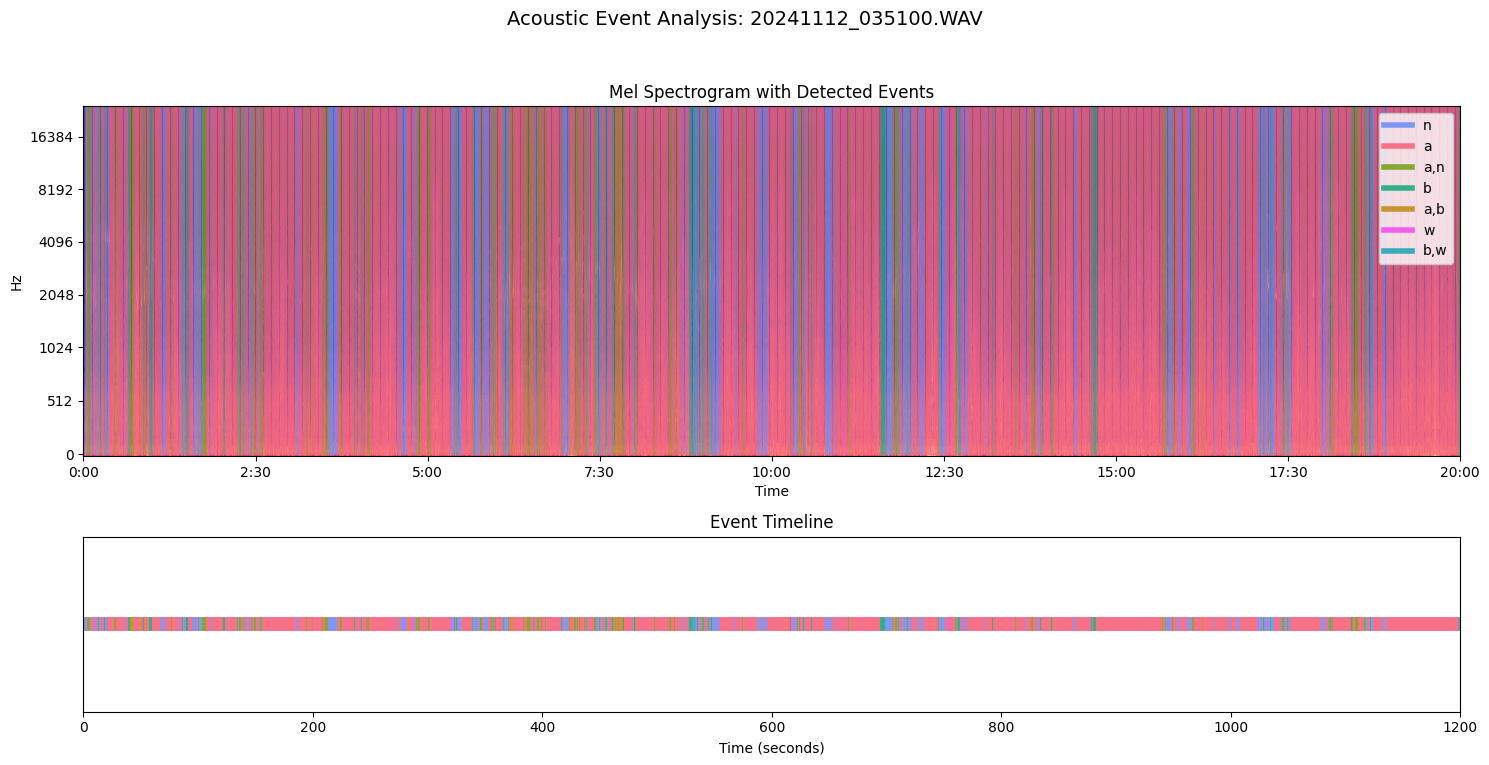

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:

# do not modify
test_path = '.'
test_file_name = '20241113_022700_CC.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: a, w
Segment 2: 1s - 3s -> Predicted Classes: a
Segment 3: 2s - 4s -> Predicted Classes: a, w
Segment 4: 3s - 5s -> Predicted Classes: b
Segment 5: 4s - 6s -> Predicted Classes: b
Segment 6: 5s - 7s -> Predicted Classes: b
Segment 7: 6s - 8s -> Predicted Classes: b
Segment 8: 7s - 9s -> Predicted Classes: b
Segment 9: 8s - 10s -> Predicted Classes: a, w
Segment 10: 9s - 11s -> Predicted Classes: w
Segment 11: 10s - 12s -> Predicted Classes: b
Segment 12: 11s - 13s -> Predicted Classes: b
Segment 13: 12s - 14s -> Predicted Classes: b
Segment 14: 13s - 15s -> Predicted Classes: a
Segment 15: 14s - 16s -> Predicted Classes: a
Segment 16: 15s - 17s -> Predicted Classes: a
Segment 17: 16s - 18s -> Predicted Classes: a
Segment 18: 17s - 19s -> Predicted Classes: b
Segment 19: 18s - 20s -> Predicted Classes: a, w
Segment 20: 19s - 21s -> Predicted Classes: a
Segment 21: 20s - 22s -> Predicted Classes: a
Segment 22: 21s - 23s -> Predicted Classes: a, w


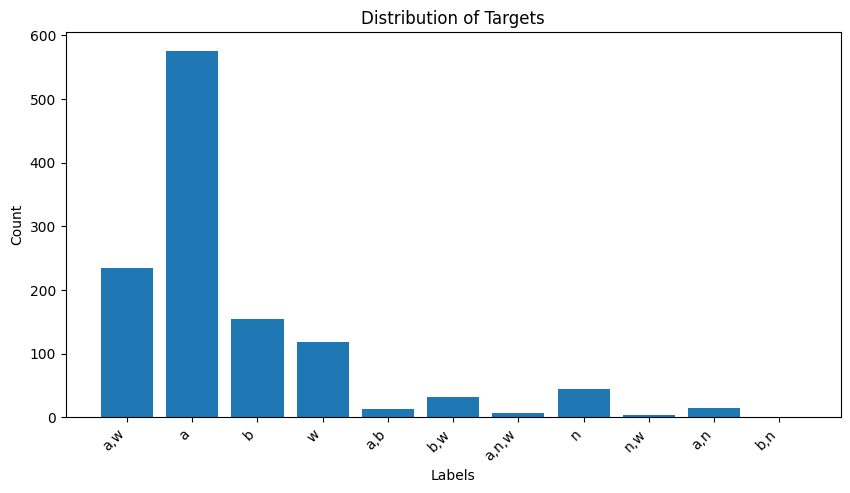

In [ ]:
label_dist(predicted_classes)

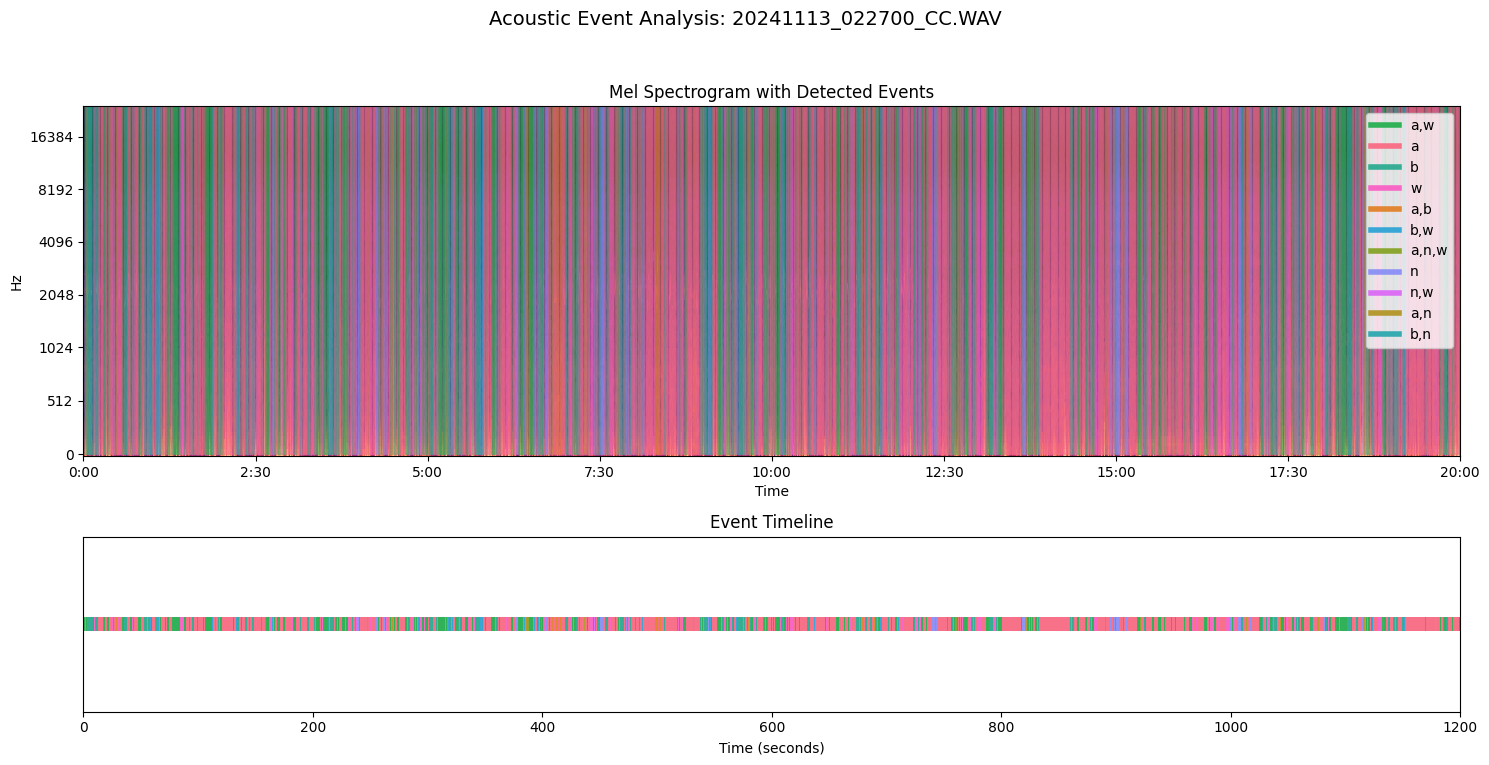

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241113_092100_AIMS.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: a, n
Segment 2: 1s - 3s -> Predicted Classes: a, n
Segment 3: 2s - 4s -> Predicted Classes: a, n
Segment 4: 3s - 5s -> Predicted Classes: a, n
Segment 5: 4s - 6s -> Predicted Classes: n
Segment 6: 5s - 7s -> Predicted Classes: a, n
Segment 7: 6s - 8s -> Predicted Classes: a, n
Segment 8: 7s - 9s -> Predicted Classes: a
Segment 9: 8s - 10s -> Predicted Classes: a, n
Segment 10: 9s - 11s -> Predicted Classes: a, n
Segment 11: 10s - 12s -> Predicted Classes: a, n
Segment 12: 11s - 13s -> Predicted Classes: a, n
Segment 13: 12s - 14s -> Predicted Classes: a, n
Segment 14: 13s - 15s -> Predicted Classes: a, n
Segment 15: 14s - 16s -> Predicted Classes: a, n
Segment 16: 15s - 17s -> Predicted Classes: a, n
Segment 17: 16s - 18s -> Predicted Classes: n
Segment 18: 17s - 19s -> Predicted Classes: a, n
Segment 19: 18s - 20s -> Predicted Classes: a, n
Segment 20: 19s - 21s -> Predicted Classes: a, n
Segment 21: 20s - 22s -> Predicted Classes: a, n
Segment

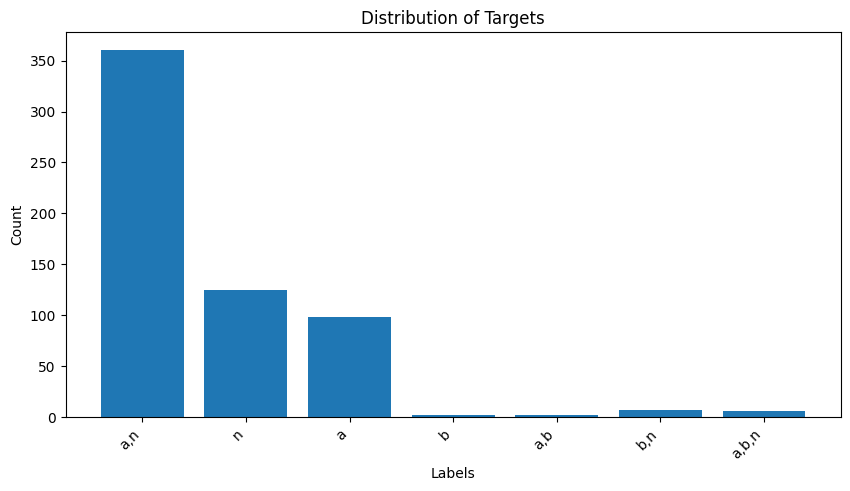

In [ ]:
label_dist(predicted_classes)

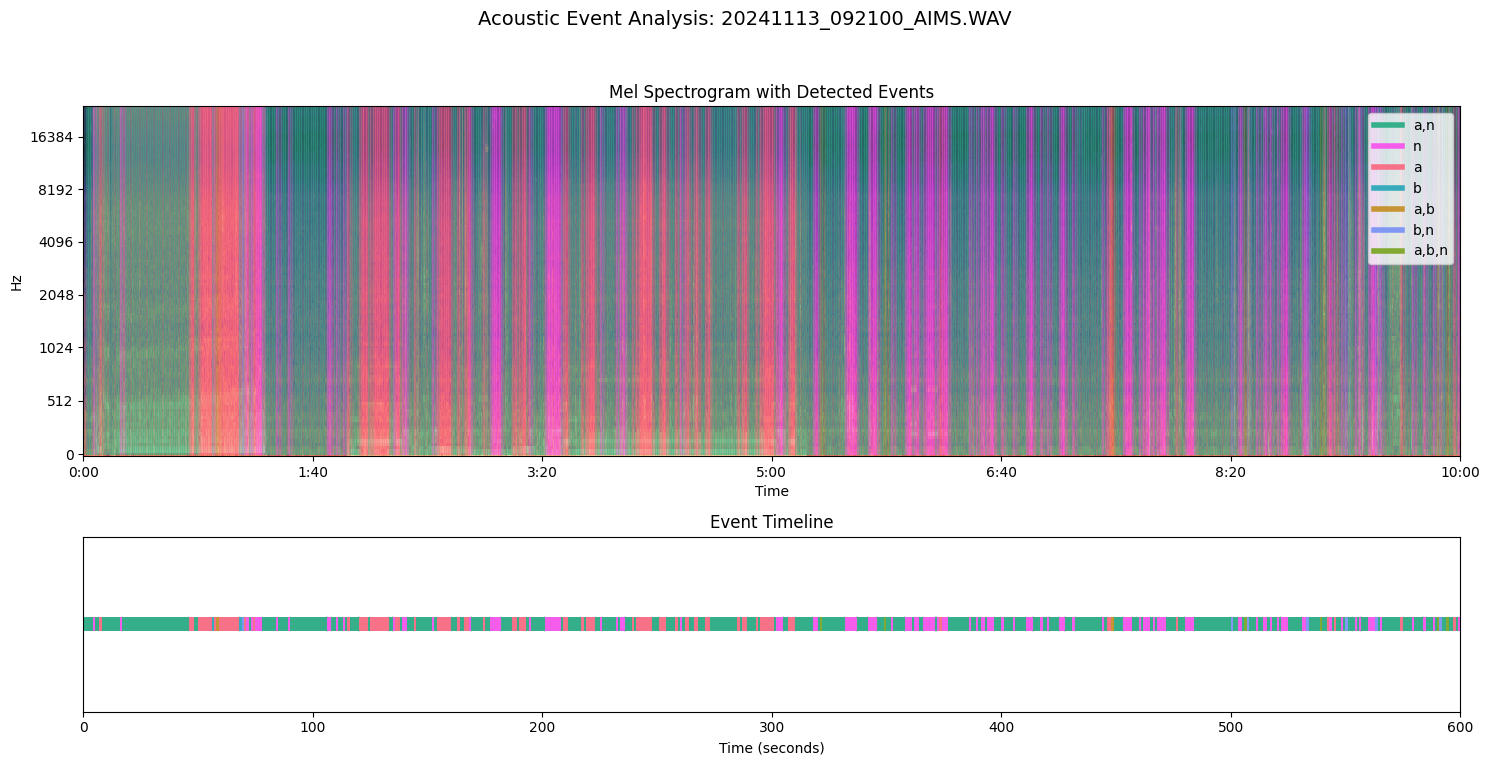

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])

In [ ]:
# do not modify
test_path = '.'
test_file_name = '20241113_102700_AIMS.WAV'

pred, segments, predicted_classes, class_labels,original_preds = predict_single_file(test_file_name, test_path, model)

Segment 1: 0s - 2s -> Predicted Classes: n
Segment 2: 1s - 3s -> Predicted Classes: n
Segment 3: 2s - 4s -> Predicted Classes: n
Segment 4: 3s - 5s -> Predicted Classes: n
Segment 5: 4s - 6s -> Predicted Classes: n
Segment 6: 5s - 7s -> Predicted Classes: n
Segment 7: 6s - 8s -> Predicted Classes: n
Segment 8: 7s - 9s -> Predicted Classes: n
Segment 9: 8s - 10s -> Predicted Classes: n
Segment 10: 9s - 11s -> Predicted Classes: b, n
Segment 11: 10s - 12s -> Predicted Classes: n
Segment 12: 11s - 13s -> Predicted Classes: n
Segment 13: 12s - 14s -> Predicted Classes: n
Segment 14: 13s - 15s -> Predicted Classes: n
Segment 15: 14s - 16s -> Predicted Classes: n
Segment 16: 15s - 17s -> Predicted Classes: b, n
Segment 17: 16s - 18s -> Predicted Classes: b, n
Segment 18: 17s - 19s -> Predicted Classes: n
Segment 19: 18s - 20s -> Predicted Classes: n
Segment 20: 19s - 21s -> Predicted Classes: n
Segment 21: 20s - 22s -> Predicted Classes: n
Segment 22: 21s - 23s -> Predicted Classes: n
Segmen

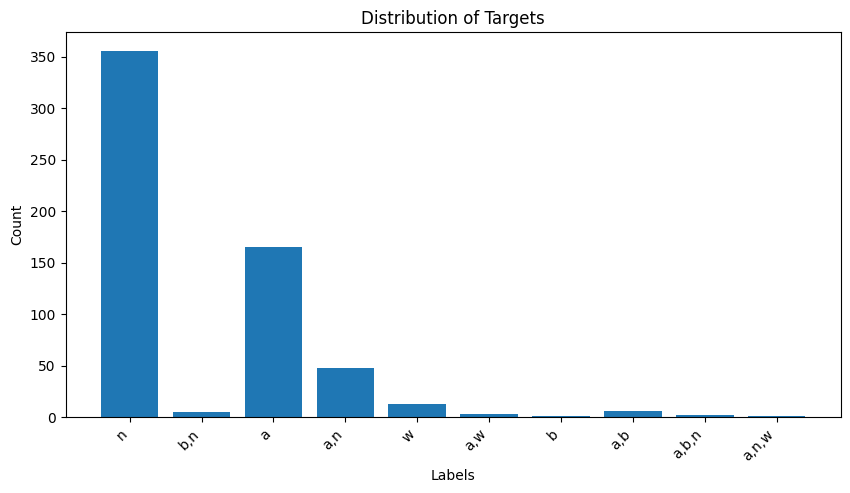

In [ ]:
label_dist(predicted_classes)

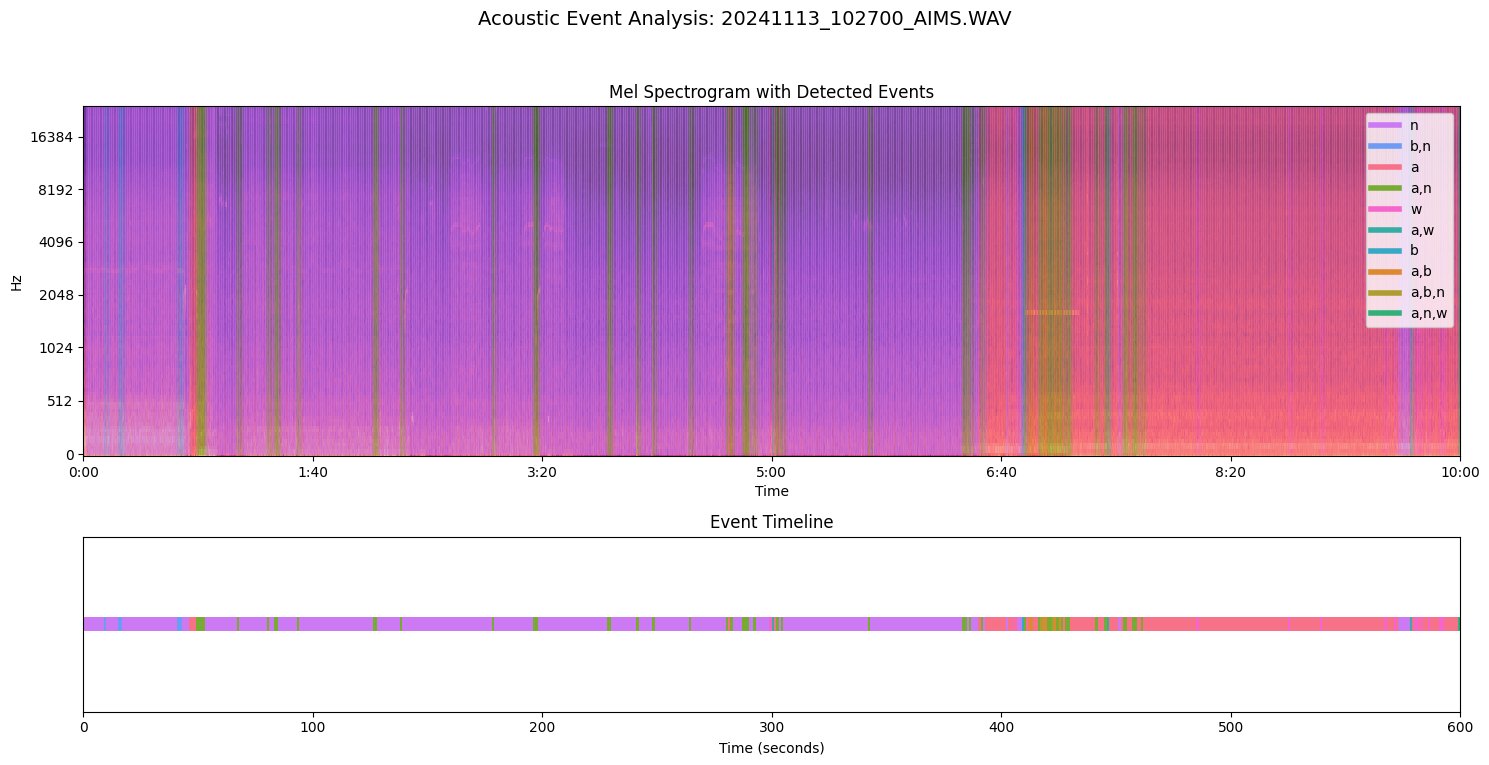

In [ ]:
predict_and_plot(test_file_name, test_path, model, label_names,[pred, segments, predicted_classes, class_labels, original_preds])